In [1]:
%load_ext autoreload
%autoreload 2

# Variational Autoencoders (VAEs)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## 1. Naive VAEs

In [4]:
batch_size = 128
epochs = 20
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten 28x28 to 784
])

train_dataset = datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='../data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
from NaiveVAE import NaiveVAE

input_dim = 784    # 28*28 pixels.
hidden_dim = 400
latent_dim = 20
model = NaiveVAE(input_dim, hidden_dim, latent_dim).to(device)

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
model.train()
for epoch in range(1, epochs + 1):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch} Average loss: {avg_loss:.4f}')

Epoch 1 Average loss: 84.5754
Epoch 2 Average loss: 84.4304
Epoch 3 Average loss: 84.3113
Epoch 4 Average loss: 84.2276
Epoch 5 Average loss: 84.0905
Epoch 6 Average loss: 84.0392
Epoch 7 Average loss: 83.9716
Epoch 8 Average loss: 83.8458
Epoch 9 Average loss: 83.7953
Epoch 10 Average loss: 83.7145
Epoch 11 Average loss: 83.6463
Epoch 12 Average loss: 83.5572
Epoch 13 Average loss: 83.4903
Epoch 14 Average loss: 83.4431
Epoch 15 Average loss: 83.3707
Epoch 16 Average loss: 83.3044
Epoch 17 Average loss: 83.2827
Epoch 18 Average loss: 83.2172
Epoch 19 Average loss: 83.1583
Epoch 20 Average loss: 83.1026


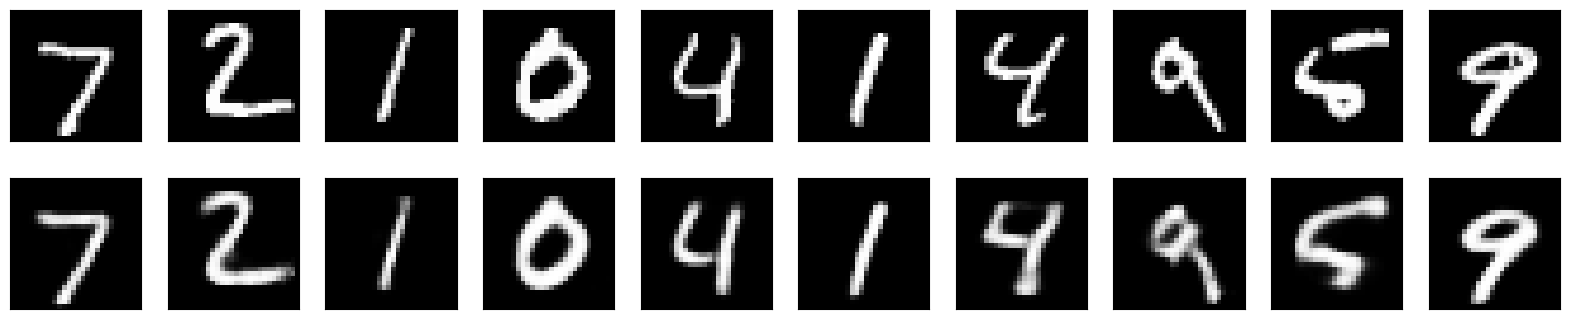

In [7]:
def plot_reconstructions(original, reconstructed, n=10):
    original = original.view(-1, 28, 28).cpu().numpy()
    reconstructed = reconstructed.view(-1, 28, 28).cpu().numpy()
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

model.eval()
with torch.no_grad():
    test_data, _ = next(iter(test_loader))
    test_data = test_data.to(device)
    recon_data, _, _ = model(test_data)

plot_reconstructions(test_data, recon_data, n=10)

# 2. Convolutional VAE

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='../data', train=True,
                                 transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='../data', train=False,
                                transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
from ConvolutionalVAE import ConvVAE

latent_dim = 128
batch_size = 128
epochs = 100
learning_rate = 3e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvVAE(latent_dim).to(device)

def vae_loss(recon_x, x, mu, logvar):
    # For image reconstruction, we can use binary cross entropy.
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + model.beta*KLD

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
model.train()
for epoch in range(1, epochs + 1):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)   # data shape: (batch, 3, 32, 32)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}, Beta: {model.beta}')

Epoch 1, Average Loss: 73.3437, Beta: 0.0391
Epoch 2, Average Loss: 45.3973, Beta: 0.0782
Epoch 3, Average Loss: 43.5771, Beta: 0.1173
Epoch 4, Average Loss: 44.2771, Beta: 0.1564
Epoch 5, Average Loss: 46.0623, Beta: 0.1955
Epoch 6, Average Loss: 48.1577, Beta: 0.2346
Epoch 7, Average Loss: 50.1700, Beta: 0.2737
Epoch 8, Average Loss: 52.0357, Beta: 0.3128
Epoch 9, Average Loss: 53.7779, Beta: 0.3519
Epoch 10, Average Loss: 55.5651, Beta: 0.391
Epoch 11, Average Loss: 57.1676, Beta: 0.4301
Epoch 12, Average Loss: 58.8659, Beta: 0.4692
Epoch 13, Average Loss: 60.3537, Beta: 0.5083
Epoch 14, Average Loss: 61.6903, Beta: 0.5474
Epoch 15, Average Loss: 62.9747, Beta: 0.5865
Epoch 16, Average Loss: 64.2943, Beta: 0.6256
Epoch 17, Average Loss: 65.4313, Beta: 0.6647
Epoch 18, Average Loss: 66.6772, Beta: 0.7038
Epoch 19, Average Loss: 67.7154, Beta: 0.7429
Epoch 20, Average Loss: 68.8653, Beta: 0.782
Epoch 21, Average Loss: 69.8662, Beta: 0.8211
Epoch 22, Average Loss: 70.8380, Beta: 0.8602

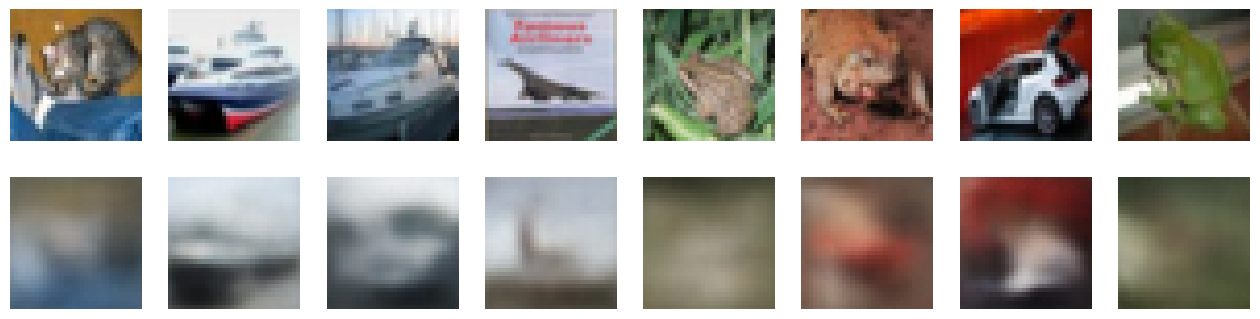

In [25]:
model.eval()
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)
    recon_images, _, _ = model(test_images)

def plot_images(original, reconstructed, n=8):
    original = original.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    plt.figure(figsize=(16, 4))
    for i in range(n):
        # Original images.
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].transpose(1, 2, 0))
        plt.axis('off')
        # Reconstructed images.
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].transpose(1, 2, 0))
        plt.axis('off')
    plt.show()

plot_images(test_images, recon_images, n=8)